In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data
import plot

from chatty.utils import cleaning

Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [3]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

Using Cached


In [421]:
# LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
# train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

In [6]:
train['utter_t-1'] = data.get_lags(train[['utter']], lag_range=[1])

In [7]:
train

person                                              utter  \
conv                                                                    
0     0   person_a                              The kitchen stinks .    
      1   person_b                      I'll throw out the garbage .    
1     0   person_a  So Dick , how about getting some coffee for to...   
      1   person_b   Coffee ? I don ’ t honestly like that kind of...   
      2   person_a   Come on , you can at least try a little , bes...   
      3   person_b   What ’ s wrong with that ? Cigarette is the t...   
      4   person_a                               Not for me , Dick .    
2     0   person_a  Are things still going badly with your housegu...   
      1   person_b   Getting worse . Now he ’ s eating me out of h...   
      2   person_a   Leo , I really think you ’ re beating around ...   
      3   person_b   You ’ re right . Everything is probably going...   
3     0   person_a                  Would you mind waiting a while ?    
      1   person_b                      Well , how long will it be ?    
      2   person_a   I'm not sure . But I'll get a table ready as ...   
      3   person_b                                 OK . We'll wait .    
4     0   person_a  Are you going to the annual party ? I can give...   
      1   person_b   Thanks a lot . That's the favor I was going t...   
      2   person_a                            The pleasure is mine .    
5     0   person_a  Isn ’ t he the best instructor ? I think he ’ ...   
      1   person_b      I swear , I ’ m going to kill you for this .    
      2   person_a   What ’ s wrong ? Didn ’ t you think it was fu...   
      3   person_b   Oh , yeah ! I had a blast ! I love sweating l...   
      4   person_a   Oh , no , get off it . It wasn ’ t such a kil...   
      5   person_b                      I am wiped out . Thank you .    
      6   person_a   Look , next time get yourself some comfy shoe...   
      7   person_b           Never ! But thank you for inviting me .    
      8   person_a   Come on . You ’ ll feel better after we hit t...   
6     0   person_a  Can I take your order now or do you still want...   
      1   person_b   Well , I want a fillet steak , medium , but m...   
      2   person_a   Certainly . How about spaghetti with clams an...   
...            ...                                                ...   
13114 0   person_a  Lindsay Tipping gave me your name as a referen...   
      1   person_b   Lindsay , of course , I will be more than hap...   
      2   person_a     How long was she employed with your company ?    
      3   person_b   She freelanced with us for 3 years . She was ...   
      4   person_a   Freelance , hmm . How do you think she will m...   
      5   person_b   She ’ s a consummate professional and a team-...   
13115 0   person_a  The consignments of chemical instruments have ...   
      1   person_b                         Is there anything wrong ?    
      2   person_a   We bought 1,000 sets of chemical instruments ...   
      3   person_b   It's hard for us to believe it . Our instrume...   
      4   person_a   Here is the survey report from a well-known p...   
      5   person_b   Well . According to the contract , we are res...   
      6   person_a   Forty faulty instruments means that 4 % are n...   
      7   person_b   I am sorry about the quality problem , but I ...   
      8   person_a   All right . In that case we are still willing...   
13117 0   person_a   May I ask you a few questions about insurance ?    
      1   person_b                                             Yes .    
      2   person_a   Now we've given a CIF Shanghai price for some...   
      3   person_b   Well . Obviously , you won ’ t want All Risks...   
      4   person_a                                         Why not ?    
      5   person_b   Because they aren ’ t delicate goods and won ...   
      6   person_a   Then am I right in understanding that FPA doe... 

### Classify Dialogue Acts

### First shot Random forest, word vectors, handful of others (need to include POS stuff)

In [8]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [49]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5)

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.27979562 0.0947462  0.59246918 0.032989  ]
 [0.04072916 0.39440165 0.38677446 0.17809473]
 [0.05075937 0.05890812 0.87120945 0.01912306]
 [0.00651681 0.06809596 0.05983189 0.86555535]]


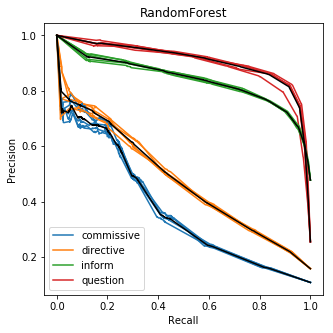

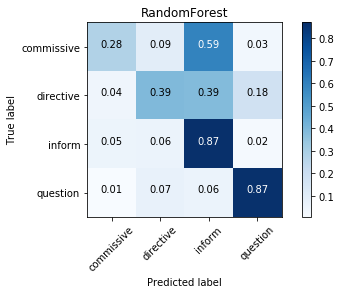

In [9]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Question marks are very important!

In [374]:
model = results['models'][0]

In [197]:
features = sorted(zip(model.feature_importances_, [str(i) for i in range(300)] + TRAIN_MASK), key=lambda x: x[0], reverse=True)

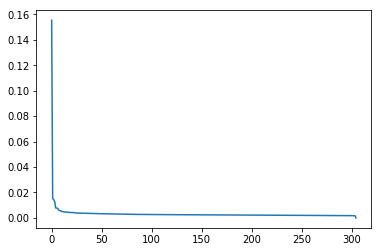

In [200]:
plt.plot(list(zip(*features))[0])

Commissive and Directives are being confused with inform. 

Given the strength of the question mark. 

I think our word vectors are doing very little to help us here. 

I think it's time to introduce some parts of speech tags along with n-grams to capture the use of commissive words and an "I" before them. 

### 20 and 21 are duplicates

In [155]:
def class_dist(col, df):
    nums = []
    for i in np.arange(0, 1, .1):
        nums.append(df[df[col] > i].shape[0] / df.shape[0])
    plt.plot(np.arange(0, 1, .1), nums, label=col)
    plt.legend()

def plot_confusion_contour(df):
    for cls in results['classes']:
        class_dist(cls, df)

def make_proba_df(results):
    y_proba = pd.DataFrame(np.concatenate(results['y_proba']))
    y_true = pd.concat(results['y_true'])
    y_proba.index = y_true.index
    y_proba.columns = results['classes']
    return y_proba

df = train.join(make_proba_df(results))

df = df[['utter', 'act'] + list(results['classes'])]

In [396]:
commissive = df[(df['act'] == 'commissive')]
commissive = commissive.sort_values('commissive', ascending=True)

In [408]:
num = 100
commissive.iloc[num]['utter']

' Bill Black , Room 1201 . '

In [422]:
commissive.iloc[num]

utter          Bill Black , Room 1201 . 
act                           commissive
commissive                             0
directive                            0.2
inform                               0.8
question                               0
Name: (1714, 8), dtype: object

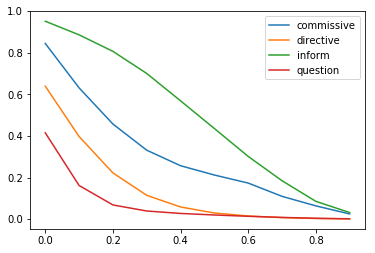

In [388]:
plot_confusion_contour(commissive)

### Start using spacy

In [20]:
import spacy
from spacy import displacy

nlp = spacy.load("en")

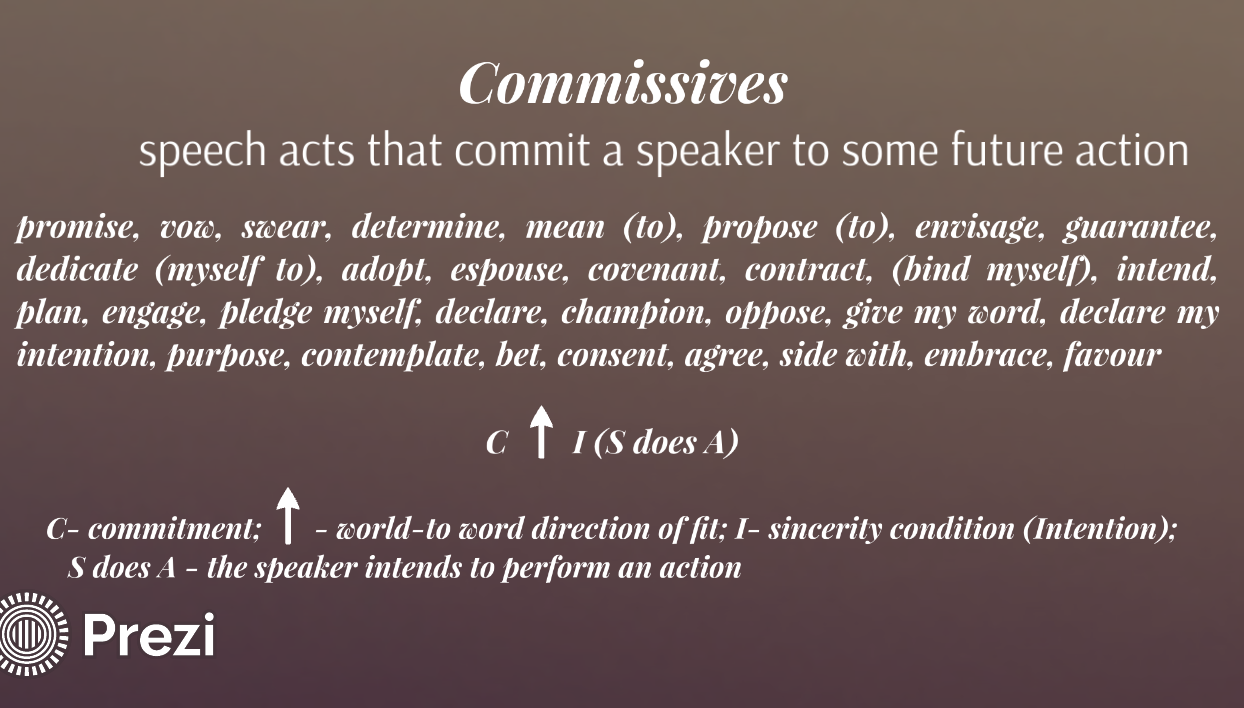

In [423]:
docs = [nlp(i) for i in commissive.iloc[100:110].sort_values('directive', ascending=False)['utter'].tolist()]

In [424]:
commissive.iloc[100:110].sort_values('directive', ascending=False)

,,utter,act,commissive,directive,inform,question
conv,,,,,,,
1849,1,"Yeah , Please do . Now let me show you the ho...",commissive,0.0,0.9,0.1,0.0
8556,26,Alright . I'll have another drink .,commissive,0.0,0.3,0.6,0.1
3405,8,Then you're not going to go to sleep .,commissive,0.0,0.3,0.2,0.5
1714,8,"Bill Black , Room 1201 .",commissive,0.0,0.2,0.8,0.0
8576,4,Sure ! Let ’ s have some nachos and mozzarell...,commissive,0.0,0.2,0.7,0.1
8566,7,Great ! Phew ! That was a close one ! You had...,commissive,0.0,0.2,0.8,0.0
8556,24,I thought a university was for studying .,commissive,0.0,0.2,0.8,0.0
3509,8,"That might be a little too much , but we ’ ll...",commissive,0.0,0.1,0.8,0.1
8928,1,"Dear , this bakery has introduced some new ty...",commissive,0.0,0.1,0.7,0.2


In [425]:
displacy.render(docs, style='dep', jupyter=True, options={'distance': 110})

In [372]:
spacy.explain('DET')

'determiner'

# Trying spacy

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.pipeline import Pipeline
import string

punctuations = string.punctuation

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [tok for tok in tokens
              if (tok.lemma_.lower().strip() not in punctuations \
                  or tok.lemma_.lower().strip() not in stopwords)]
    tokens = [tok.lemma_.lower().strip() +
#                "_DEP_" + tok.dep_ + "_POS_" + tok.pos_
                "_DEP_" + tok.dep_
              if tok.lemma_ != "-PRON-" else tok.lower_ 
              for tok in tokens]
    return tokens

#Custom transformer using spaCy 
class Cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic utility function to clean the text 
def clean_text(text):     
    if text is None or text is np.nan:
        return ''
    return text.strip().lower()

In [41]:
pipe = Pipeline([("cleaner", Cleaner()),
                 ('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer)),
                 ('RF', RandomForestClassifier(n_jobs=-1))])

# Only using text

In [58]:
vec = CountVectorizer(tokenizer=spacy_tokenizer)
utter_vecs = vec.fit_transform(train['utter'])

# Didn't work

### Try Bayes with TFIDF (also include POS)

In [208]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [209]:
results = data.cv_stratified_shuffle(X, y,
                                     BernoulliNB(),
                                     splits=5)

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.32078196 0.29223592 0.33644341 0.05053871]
 [0.06117001 0.62748837 0.18587446 0.12546716]
 [0.16857561 0.22105051 0.56614865 0.04422524]
 [0.03962032 0.18398187 0.11144692 0.66495089]]


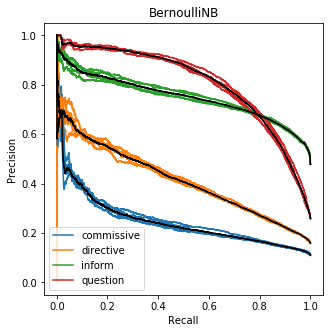

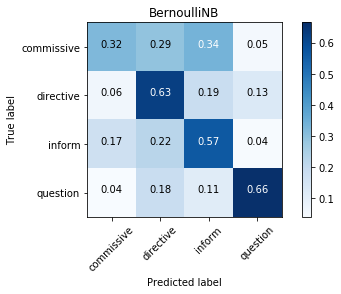

In [210]:
title = "BernoulliNB"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);